In [108]:
import numpy as np
import matplotlib.pyplot as plt
from utils import ValueColorMapper

In [200]:
def quantize_curve(curve, quantization_levels):
    quantized_curve = np.zeros_like(curve)

    for i in range(len(curve)):
        nearest_level = quantization_levels[np.argmin(np.abs(quantization_levels - curve[i]))]
        quantized_curve[i] = nearest_level
    
    return quantized_curve

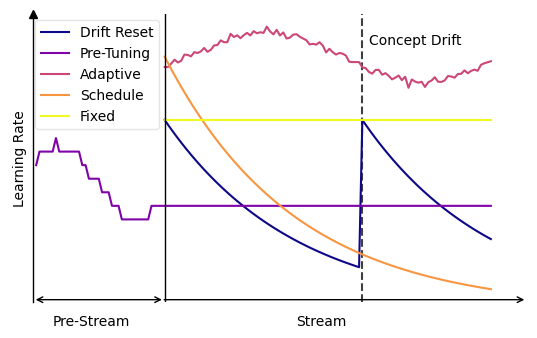

<Figure size 640x480 with 0 Axes>

In [207]:
# Generate data
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 1

n_stream = 100
n_tuning = 40
xs = np.arange(n_tuning, n_stream + n_tuning)
xs_tuning = np.arange(n_tuning) + 1
initial_lr = 0.1
drift_at = 60
schedule_lr = initial_lr * 0.975 ** (xs - n_tuning)
adaptive_lr = initial_lr * (1 - 0.1 * np.sin(xs / 15)) + 0.001 * np.random.randn(
    xs.shape[0]
)
fixed_lr = 0.075 * np.ones_like(xs)
reset_lr = 0.075 * 0.975 ** np.concatenate(
    [np.arange(drift_at), np.arange(n_stream - drift_at)]
)
tuned_lr = 0.05 * (1 + 0.3 * np.cos(xs_tuning / 7.5 - 1)) + 0.001 * np.random.randn(
    xs_tuning.shape[0]
)
tuned_lr = quantize_curve(tuned_lr, np.linspace(0.025, 0.1, 15))
tuned_lr = np.concatenate([tuned_lr, np.ones(n_stream) * tuned_lr[-1]])
xs_complete = np.concatenate([xs_tuning, xs])

lrs = {
    "Drift Reset": reset_lr,
    "Pre-Tuning": tuned_lr,
    "Adaptive": adaptive_lr,
    "Schedule": schedule_lr,
    "Fixed": fixed_lr,
}

cmapper = ValueColorMapper(lrs.keys(), cmap='plasma')

# Fluctuating learning rate (Adam-like)
np.random.seed(42)
# Create the plot
fig, ax = plt.subplots(figsize=(6.5, 3.75))
# Hide the top and right spines.
ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.spines[["left"]].set_position(("data", -0.01))
# ax.plot(1, 0.0007, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

for label, ys in lrs.items():
    color = cmapper(label)
    if label == "Pre-Tuning": 
        ax.plot(xs_complete, ys, label=label, c=color)
    else: 
        ax.plot(xs, ys, label=label, c=color)

ax.set_ylabel("Learning Rate")
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
ax.axvline(
    x=n_tuning + drift_at,
    color="black",
    ymin=0.001,
    linestyle="--",
    alpha=0.75,
    zorder=0,
)
linewidth = 1
gap = -0.004
ax.axvline(x=n_tuning, color="black", ymin=-gap, linestyle="-", alpha=1, zorder=3, lw=linewidth)
ax.text(x=n_tuning + drift_at + 2, y=initial_lr + 0.005, s="Concept Drift")
ax.text(x=6, y=-0.006, s="Pre-Stream")
ax.text(x=80, y=-0.006, s="Stream")
plt.annotate(text='', xy=(0,-gap), xytext=(n_tuning, -gap), arrowprops=dict(arrowstyle='<->', lw=linewidth))
plt.annotate(text='', xy=(n_tuning-1, -gap), xytext=(n_tuning+n_stream+10, -gap), arrowprops=dict(arrowstyle='<-', lw=linewidth))
plt.legend(loc=(0.05, 0.6), framealpha=0.5)
plt.show()
plt.tight_layout()
fig.savefig("../pub/figures/lr_overview.pdf", bbox_inches='tight')